In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline

#Loading the dataset
dataset = pd.read_csv("../Data/Emoutions_texts/emotion.data")

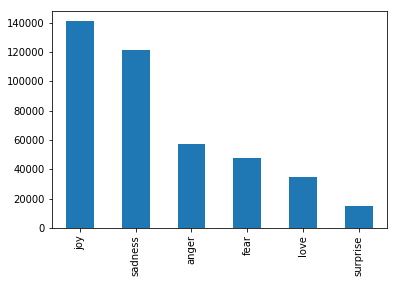

In [2]:
# Plot label histogram
dataset.emotions.value_counts().plot.bar()

In [3]:
dataset.head(10)

,Unnamed: 0,text,emotions
0,27383,i feel awful about it too because it s my job ...,sadness
1,110083,im alone i feel awful,sadness
2,140764,ive probably mentioned this before but i reall...,joy
3,100071,i was feeling a little low few days back,sadness
4,2837,i beleive that i am much more sensitive to oth...,love
5,18231,i find myself frustrated with christians becau...,love
6,10714,i am one of those people who feels like going ...,joy
7,35177,i feel especially pleased about this as this h...,joy
8,122177,i was struggling with these awful feelings and...,joy
9,26723,i feel so enraged but helpless at the same time,anger


In [4]:
input_sentences = [text.split(" ") for text in dataset["text"].values.tolist()]
labels = dataset["emotions"].values.tolist()

In [5]:
# Initialize word2id and label2id dictionaries that will be used to encode words and labels
word2id = dict()
label2id = dict()

max_words = 0 # maximum number of words in a sentence

# Construction of word2id dict
for sentence in input_sentences:
    for word in sentence:
        # Add words to word2id dict if not exist
        if word not in word2id:
            word2id[word] = len(word2id)
    # If length of the sentence is greater than max_words, update max_words
    if len(sentence) > max_words:
        max_words = len(sentence)
    
# Construction of label2id and id2label dicts
label2id = {l: i for i, l in enumerate(set(labels))}
id2label = {v: k for k, v in label2id.items()}
id2label

{0: 'sadness', 1: 'anger', 2: 'fear', 3: 'surprise', 4: 'joy', 5: 'love'}

In [6]:
!pip install keras

The directory '/home/ec2-user/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/ec2-user/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.


In [7]:
!sudo pip install tensorflow

The directory '/home/ec2-user/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/ec2-user/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.


In [8]:
!sudo pip3 install tensorflow

The directory '/home/ec2-user/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/ec2-user/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.


In [16]:
!pip install --ignore-installed --upgrade tensorflow==1.14.0


The directory '/home/ec2-user/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/ec2-user/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
    100% |████████████████████████████████| 109.3MB 798kB/s  eta 0:00:01
    100% |████████████████████████████████| 51kB 56.5MB/s ta 0:00:01
    100% |████████████████████████████████| 112kB 62.5MB/s ta 0:00:01
    100% |████████████████████████████████| 20.0MB 4.1MB/s  eta 0:00:01
    100% |████████████████████████████████| 51kB 44.5MB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 71.8MB/s ta 0:00:01
    100% |████████████████████████████████| 1.3MB 2.5MB/s ta 0:00:0101
    100% |

In [23]:
import keras

# Encode input words and labels
X = [[word2id[word] for word in sentence] for sentence in input_sentences]
Y = [label2id[label] for label in labels]

# Apply Padding to X
from keras.preprocessing.sequence import pad_sequences
X = pad_sequences(X, max_words)

# Convert Y to numpy array
Y = keras.utils.to_categorical(Y, num_classes=len(label2id), dtype='float32')

# Print shapes
print("Shape of X: {}".format(X.shape))
print("Shape of Y: {}".format(Y.shape))


Shape of X: (416809, 178)
Shape of Y: (416809, 6)


In [24]:
embedding_dim = 100 # The dimension of word embeddings

# Define input tensor
sequence_input = keras.Input(shape=(max_words,), dtype='int32')

# Word embedding layer
embedded_inputs =keras.layers.Embedding(len(word2id) + 1,
                                        embedding_dim,
                                        input_length=max_words)(sequence_input)

# Apply dropout to prevent overfitting
embedded_inputs = keras.layers.Dropout(0.2)(embedded_inputs)

# Apply Bidirectional LSTM over embedded inputs
lstm_outs = keras.layers.wrappers.Bidirectional(
    keras.layers.LSTM(embedding_dim, return_sequences=True)
)(embedded_inputs)

# Apply dropout to LSTM outputs to prevent overfitting
lstm_outs = keras.layers.Dropout(0.2)(lstm_outs)

# Attention Mechanism - Generate attention vectors
input_dim = int(lstm_outs.shape[2])
permuted_inputs = keras.layers.Permute((2, 1))(lstm_outs)
attention_vector = keras.layers.TimeDistributed(keras.layers.Dense(1))(lstm_outs)
attention_vector = keras.layers.Reshape((max_words,))(attention_vector)
attention_vector = keras.layers.Activation('softmax', name='attention_vec')(attention_vector)
attention_output = keras.layers.Dot(axes=1)([lstm_outs, attention_vector])

# Last layer: fully connected with softmax activation
fc = keras.layers.Dense(embedding_dim, activation='relu')(attention_output)
output = keras.layers.Dense(len(label2id), activation='softmax')(fc)

# Finally building model
model = keras.Model(inputs=[sequence_input], outputs=output)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer='adam')

# Print model summary
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 178)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 178, 100)     7530300     input_2[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 178, 100)     0           embedding_2[0][0]                
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 178, 200)     160800      dropout_3[0][0]                  
____________________________________________________________________________________________

In [25]:
model.fit(X, Y, epochs=2, batch_size=64, validation_split=0.1, shuffle=True)
# model = keras.models.load_model('ner1.h5')

Train on 375128 samples, validate on 41681 samples
Epoch 1/2
375128/375128 [==============================] - 919s 2ms/step - loss: 0.1912 - accuracy: 0.9062 - val_loss: 0.1011 - val_accuracy: 0.9384
Epoch 2/2
375128/375128 [==============================] - 909s 2ms/step - loss: 0.0917 - accuracy: 0.9413 - val_loss: 0.0908 - val_accuracy: 0.9411


In [26]:
model_with_attentions = keras.Model(inputs=model.input,
                                    outputs=[model.output, 
                                             model.get_layer('attention_vec').output])

In [28]:
model.save('ner1.h5')

In [29]:
model_with_attentions.save('ner1_attention.h5')

In [74]:
import random
import math

# Select random samples to illustrate
sample_text = open("untitled.txt").read().replace('\n','')

sample_text = sample_text.lower()
sample_text

'table of contentschapter onechapter twochapter threechapter fourchapter fivechapter sixchapter sevenchapter eightchapter ninechapter tenchapter elevenchapter twelvechapter thirteenchapter fourteenchapter fifteenchapter sixteenchapter seventeenchapter eighteenchapter nineteenchapter twentychapter twenty-onechapter twenty-twochapter twenty-threechapter twenty-fourchapter twenty-fivechapter twenty-sixchapter twenty-sevenchapter twenty-eightchapter twenty-ninechapter thirtychapter thirty-onechapter thirty-twochapter thirty-threechapter thirty-fourchapter thirty-fivesilenceby natasha prestoncopyright 2012 © natasha prestonwithout limiting the rights under copyright reserved above, no part of thispublication may be reproduced, stored in or introduced into a retrieval system, ortransmitted, in any form, or by any means (electronic, mechanical, photo- copying,recording, or otherwise) without the prior written permission of both the copyright ownerand the above publisher of this book.this is a

In [75]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
sw_ru = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [76]:
sample_text_clean = ' '.join([word for word in sample_text.split() if not word in sw_ru])
print('До {} слов'.format(len(sample_text.split())))
print('После {} слов'.format(len(sample_text_clean.split())))

До 74362 слов
После 41443 слов


In [77]:
import re
res = re.sub(r'[\.,!?:-]', '', sample_text_clean)
sample_text = res
sample_text

'table contentschapter onechapter twochapter threechapter fourchapter fivechapter sixchapter sevenchapter eightchapter ninechapter tenchapter elevenchapter twelvechapter thirteenchapter fourteenchapter fifteenchapter sixteenchapter seventeenchapter eighteenchapter nineteenchapter twentychapter twentyonechapter twentytwochapter twentythreechapter twentyfourchapter twentyfivechapter twentysixchapter twentysevenchapter twentyeightchapter twentyninechapter thirtychapter thirtyonechapter thirtytwochapter thirtythreechapter thirtyfourchapter thirtyfivesilenceby natasha prestoncopyright 2012 © natasha prestonwithout limiting rights copyright reserved above part thispublication may reproduced stored introduced retrieval system ortransmitted form means (electronic mechanical photo copyingrecording otherwise) without prior written permission copyright ownerand publisher bookthis work fiction names characters placesbrands media incidents either product author’s imagination usedfictitiously author

In [78]:
res = re.findall(r'[a-zA-Z]+', sample_text)
res
text = ''
for i in res:
    if i in word2id:
        text = text + i + ' '
    
text = text.rstrip()

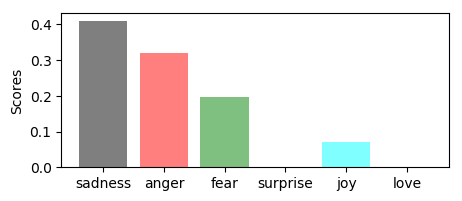

In [79]:
# Encode samples
tokenized_sample = text.split(" ")

encoded_samples = [[word2id[word] for word in tokenized_sample]]

# Padding
encoded_samples = keras.preprocessing.sequence.pad_sequences(encoded_samples, maxlen=max_words)

# Make predictions
label_probs, attentions = model_with_attentions.predict(encoded_samples)
label_probs = {id2label[_id]: prob for (label, _id), prob in zip(label2id.items(),label_probs[0])}

# Get word attentions using attenion vector
token_attention_dic = {}
max_score = 0.0
min_score = 0.0
for token, attention_score in zip(tokenized_sample, attentions[0][-len(tokenized_sample):]):
    token_attention_dic[token] = math.sqrt(attention_score)


# VISUALIZATION
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb
    
def attention2color(attention_score):
    r = 255 - int(attention_score * 255)
    color = rgb_to_hex((255, r, r))
    return str(color)
    
# Build HTML String to viualize attentions
html_text = "<hr><p style='font-size: large'><b>Text:  </b>"
for token, attention in token_attention_dic.items():
    html_text += "<span style='background-color:{};'>{} <span> ".format(attention2color(attention),
                                                                        token)
html_text += "</p>"
# Display text enriched with attention scores 
display(HTML(html_text))

# PLOT EMOTION SCORES
emotions = [label for label, _ in label_probs.items()]
scores = [score for _, score in label_probs.items()]
plt.figure(figsize=(5,2))
plt.bar(np.arange(len(emotions)), scores, align='center', alpha=0.5, color=['black', 'red', 'green', 'blue', 'cyan', "purple"])
plt.xticks(np.arange(len(emotions)), emotions)
plt.ylabel('Scores')
plt.show()